# Idea:
1. Import Speeches
2. tokenize into words
3. Train word2vec and inspect embedding space
4. Align embedding spaces using orthogonal procrustes (https://arxiv.org/pdf/1605.09096)
5. find words which have the most different meaning 

In [1]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import nltk
import string
from nltk.stem.cistem import Cistem
import spacy
from gensim.models.phrases import Phrases
from gensim.models import Word2Vec
import gensim

In [2]:
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simonkoehl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#To combine all the .csv files to one dataframe, since OpenDiscourse does not allow to download more than 200 speeches
# @param speech_count is the number of speeches to load (currently 34)
def get_corpus(path, min_chars = 10, speech_count = 34):
    df = pd.read_csv(path + "1.csv", on_bad_lines="skip",index_col="id")
    for i in range(2, speech_count+1):
        tmp = pd.read_csv(path + str(i) + ".csv", on_bad_lines="skip", index_col="id")
        df = pd.concat([df,tmp])
    #Filter out speeches that have less than min_chars characters
    df = df[df["speech"].str.len() >= min_chars]
    #Initial cleanup (interjections, non letter or digit characters, latin whitespace, ...)
    df["speech"].replace({r'\(\{[0-9]*\}\)': "", r'[^\w\s\\.\\!\\?]':' ', "\xa0": " "}, regex=True, inplace=True)
    return df

In [6]:
def remove_punctuation_and_tokenize(documents):
    cleaned_docs = []
    for doc in documents:
        #split on whitespaces
        words = doc.split()
        cleaned_doc = []
        for word in words:
            #Remove interjection characters
            word = re.sub("\(\{[0-9]*\}\)", "", word)
            word = word.strip('!"#$%&\'()*+,-./:;<=>?@[]^_`{|}~–„“§').split("\\n")
            if len(word) > 1:
                for w in word:
                    w = re.sub("\(\{[0-9]*\}\)", "", w)
                    w.replace("–", "_")
                    if w != "":
                        w = w.strip('!"#$%&\'()*+,-./:;<=>?@[]^_`{|}~–„“§') # einige könnten noch Sondernzeichen beinhalten, deswegen double check
                        cleaned_doc.append(w)
            else:
                if word[0] != "":
                    cleaned_doc.append(word[0])
        doc_string = " ".join(cleaned_doc)
        if len(doc_string) != 0:
            cleaned_docs.append(cleaned_doc)
    return cleaned_docs

def remove_stopwords(documents, language="german"):
    stopwords_ = stopwords.words(language)
    return [[x for x in clean_t if x.lower() not in stopwords_] for clean_t in documents]

def lower_documents(documents):
    return [[x.lower() for x in clean_t] for clean_t in documents]

def stem_documents(documents):
    stemmer = Cistem()
    return [[stemmer.stem(x) for x in clean_t] for clean_t in documents]

def lemmatize(documents):
    nlp = spacy.load("de_core_news_sm")
    documents_lemma = []
    docs = []
    for doc in documents:
        joined_doc = " ".join(doc)
        docs.append(joined_doc)
    for doc in nlp.pipe(docs, batch_size=32, n_process=-1, disable=["parser", "ner"]):
        res = [tok.lemma_ for tok in doc]
        documents_lemma.append(res)
    return documents_lemma

def remove_numbers(documents):
    return [[x for x in cleaned_doc if not x.isdigit()] for cleaned_doc in documents]

def cleanup(documents):
    result = []
    for doc in documents:
        tmp_doc = []
        for word in doc:
            new_word = re.sub("(--|/)", "", word)
            if len(new_word) > 1:
                tmp_doc.append(new_word)
        result.append(tmp_doc)
    return result

def filter_floskeln(documents):
    filter_out = ['präsident',
 'präsidentin',
 'kollege',
 'präsident_geehrt',
 'präsidentin_geehrt',
 'präsident_dame',
 'präsidentin_dame',
 'geehrt',
 'geehrt_kollege',
 'kollegin',
  "dame_herr"]
    return [[x for x in cleaned_doc if x not in filter_out] for cleaned_doc in documents]

"""
Custom cleaning function to clean text that is given in the wanted segments, meaning that it is pre-split.
@params: text --> list of strings which is the text split into the desired segments
@returns: desired segments as list of strings (each segment one string in the list) such that:
              - punctuation is removed
              - all text is lower case
              - interjection divider is removed
              - special characters such as /{}()\\n are removed
              - words are lemmatized
              - numerical values are removed
"""
def preprocess(documents):
    # Remove punctuation and tokenize
    result = remove_punctuation_and_tokenize(documents)
    #Get rid of stop words
    result = remove_stopwords(result)
    #Stemming
    #result = stem_documents(result)
    #Lemmatization
    #result = lemmatize(result)
    result = lower_documents(result)
    result = remove_numbers(result)
    result = cleanup(result)
    #Filter out things like "sehr geehrte damen und herren" etc. since they degrade the results
    result = filter_floskeln(result)
    return [x for x in result if len(x) > 2]

In [7]:
#This is just for computing the loss of the gensim word2vec model
from gensim.models.callbacks import CallbackAny2Vec
class LossLogger(CallbackAny2Vec):
    '''Output loss at each epoch'''
    def __init__(self):
        self.epoch = 1
        self.losses = []

    def on_epoch_begin(self, model):
        if self.epoch % 100 == 0:
            print(f'Epoch: {self.epoch}', end='\t')

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss)
        model.running_training_loss = 0.0
        if self.epoch % 100 == 0:
            print(f'  Loss: {loss}')
        if self.epoch % 100 == 0 and loss < 15000:
            model.save(f"../models/checkpoints/CHECKPOINT_{self.epoch}")
        self.epoch += 1

In [8]:
def prepare_speeches(path_to_speeches, phrasing=True, speech_count=32):
    print("Getting corpus from path...")
    speeches = get_corpus(path_to_speeches, speech_count=speech_count)
    print("Done! Now extracting speeches and preprocessing them...")
    #Get only the speeches as a list
    texts_speeches = [row["speech"] for index, row in speeches.iterrows()]
    cleaned_speeches = preprocess(texts_speeches)
    #extract phrases to fuse together statistically (e.g. "New" and "York" make more sense as "New_York")
    if phrasing:
        print("Done! Now finding 2-gram phrases...")
        phrases = Phrases(cleaned_speeches, min_count=30, progress_per=10000).freeze()
        tmp = []
        for t in phrases[cleaned_speeches]:
            if len(t) > 2:
                tmp.append(t)
        cleaned_speeches = tmp
    print("Done! Here are some statistics:")
    #get list of all tokens and show how many there are to get a feel for the size of the dataset
    ttrc = []
    total_tokens = []
    k = 0
    running_count_ttr = 0
    for sentence in cleaned_speeches:
        k += 1
        tokens = []
        for word in sentence:
            tokens.append(word)
            total_tokens.append(word)
        types = set(tokens)
        running_count_ttr += len(types)/len(tokens)
        if k % 100 == 0:
            ttrc.append(running_count_ttr / 100)
            running_count_ttr = 0
    total_types = set(total_tokens)
    print("Total number of tokens in corpus:", len(total_tokens))
    print("Total number of types in corpus:", len(total_types))
    print("TTR over whole corpus:", len(total_types)/len(total_tokens))
    fig = plt.figure()
    ax = fig.subplots()
    ax.set_title("TTRC with averaged TTR for every 100 speeches")
    ax.set_xlabel("Speeches (averaged for every 100 speeches)")
    ax.set_ylabel("TTR")
    ax.plot(range(len(ttrc)),ttrc)
    from collections import Counter
    word_freq = Counter(total_tokens)
    #Frequency Analysis
    sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
    print("20 most frequent words (normalized):", sorted_word_freq[:50])
    return cleaned_speeches

def tokenize_to_txt(documents, path):
    doc_string = ""
    for doc in documents:
        doc_string += " ".join(doc)
    with open(path, "w") as f:
        f.write(doc_string)
    return doc_string

Getting corpus from path...
Done! Now extracting speeches and preprocessing them...
Done! Now finding 2-gram phrases...
Done! Here are some statistics:
Total number of tokens in corpus: 1035093
Total number of types in corpus: 72475
TTR over whole corpus: 0.07001786312920674
20 most frequent words (normalized): [('müssen', 7210), ('mehr', 5970), ('menschen', 5480), ('ja', 5015), ('schon', 4083), ('gibt', 4074), ('sagen', 3863), ('heute', 3801), ('brauchen', 3607), ('kollegen', 3471), ('geht', 3396), ('immer', 3396), ('gerade', 3363), ('mal', 3274), ('deutschland', 3236), ('endlich', 2937), ('damen_herren', 2900), ('bundesregierung', 2888), ('ganz', 2752), ('dafür', 2745), ('deswegen', 2740), ('wirklich', 2735), ('frage', 2499), ('liebe_kolleginnen', 2497), ('gut', 2413), ('herr', 2300), ('viele', 2284), ('tun', 2261), ('vielen_dank', 2254), ('antrag', 2180), ('genau', 2139), ('land', 2121), ('deshalb', 2025), ('gesagt', 2014), ('wissen', 1931), ('wäre', 1924), ('eigentlich', 1920), ('e

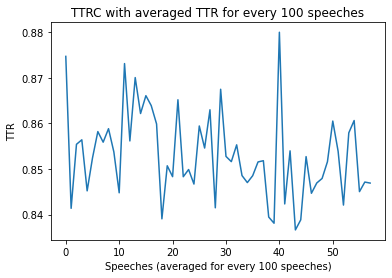

In [14]:
data = prepare_speeches("../data/gruene_data/gruene", True)

In [15]:
_ = tokenize_to_txt(data, "../data/txt/gruene.txt")

In [382]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [383]:
def tsnescatterplot(model, word, list_names, vec_dim=10, n_comp=5):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, vec_dim), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word], topn=15)
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=None).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=30).fit_transform(reduc)
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


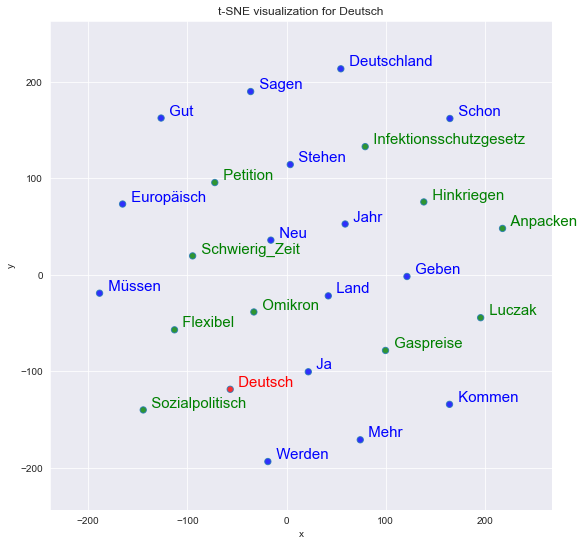

In [384]:
tsnescatterplot(model, 'deutsch', [i[0] for i in model.wv.most_similar(negative=["deutsch"])], vec_dim=DIMENSION, n_comp=PCA_COMPONENTS)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


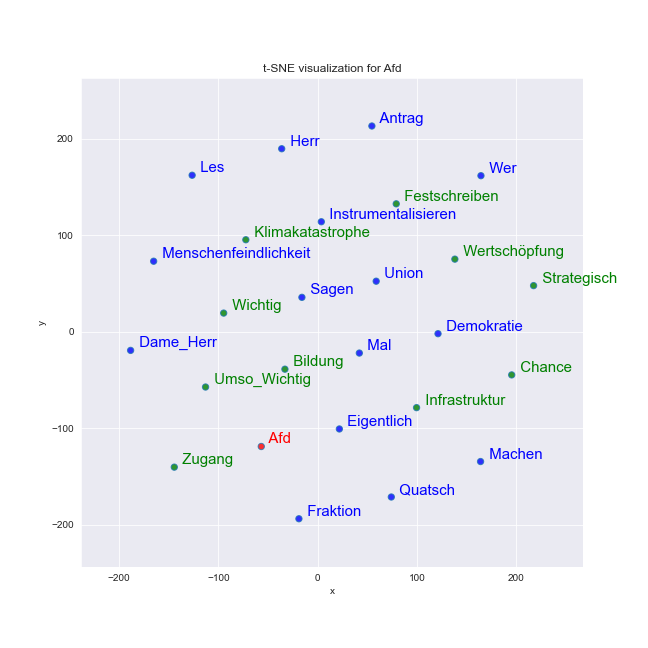

In [353]:
tsnescatterplot(model, 'afd', [i[0] for i in model.wv.most_similar(negative=["afd"])], vec_dim=DIMENSION, n_comp=PCA_COMPONENTS)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


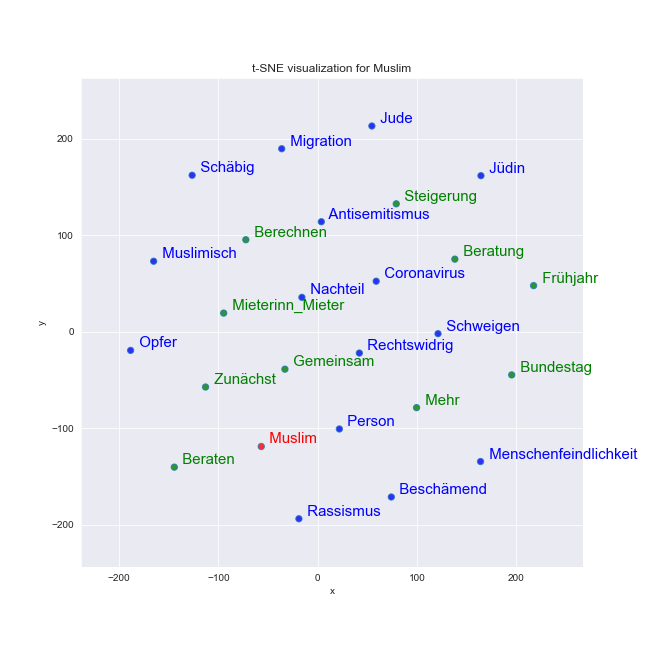

In [354]:
tsnescatterplot(model, 'muslim', [i[0] for i in model.wv.most_similar(negative=["muslim"])], vec_dim=DIMENSION, n_comp=PCA_COMPONENTS)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


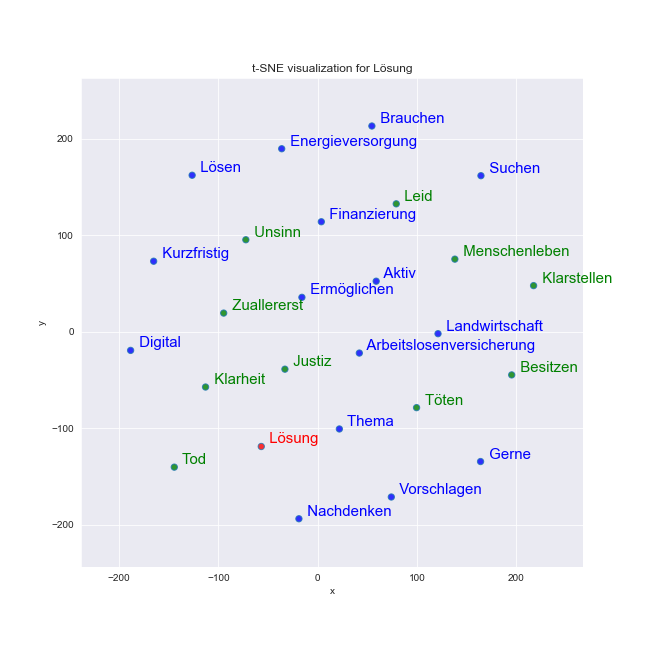

In [355]:
tsnescatterplot(model, 'lösung', [i[0] for i in model.wv.most_similar(negative=["lösung"])], vec_dim=DIMENSION, n_comp=PCA_COMPONENTS)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


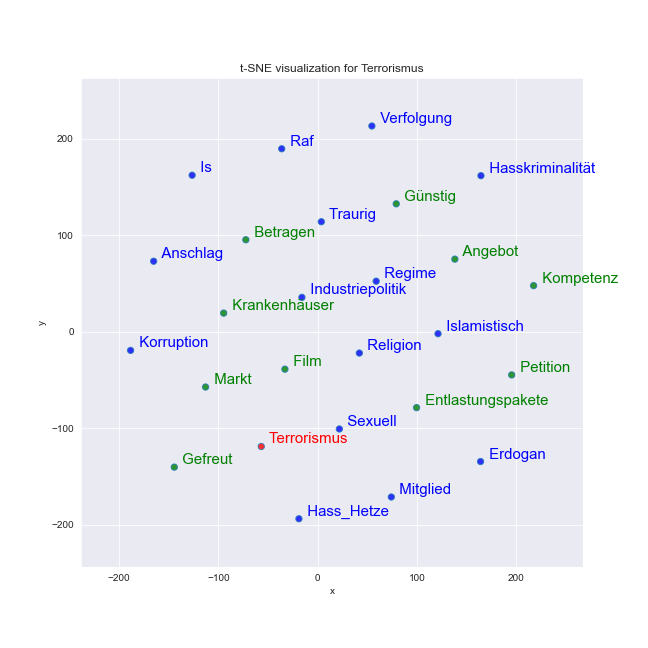

In [356]:
tsnescatterplot(model, 'terrorismus', [i[0] for i in model.wv.most_similar(negative=["terrorismus"])], vec_dim=DIMENSION, n_comp=PCA_COMPONENTS)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


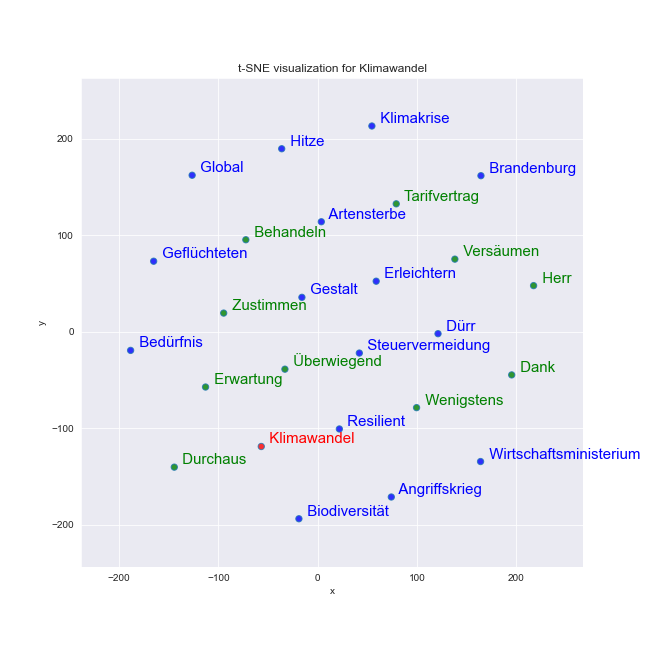

In [357]:
tsnescatterplot(model, 'klimawandel', [i[0] for i in model.wv.most_similar(negative=["klimawandel"])], vec_dim=DIMENSION, n_comp=PCA_COMPONENTS)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


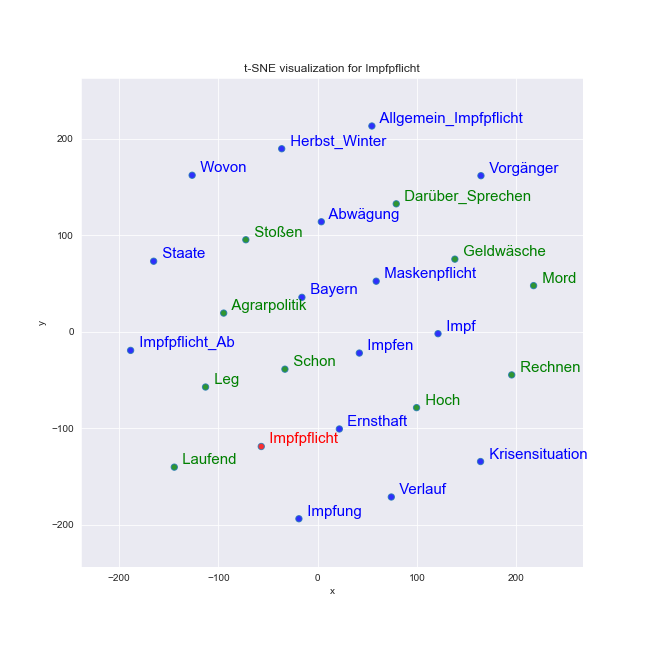

In [358]:
tsnescatterplot(model, 'impfpflicht', [i[0] for i in model.wv.most_similar(negative=["impfpflicht"])], vec_dim=DIMENSION, n_comp=PCA_COMPONENTS)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


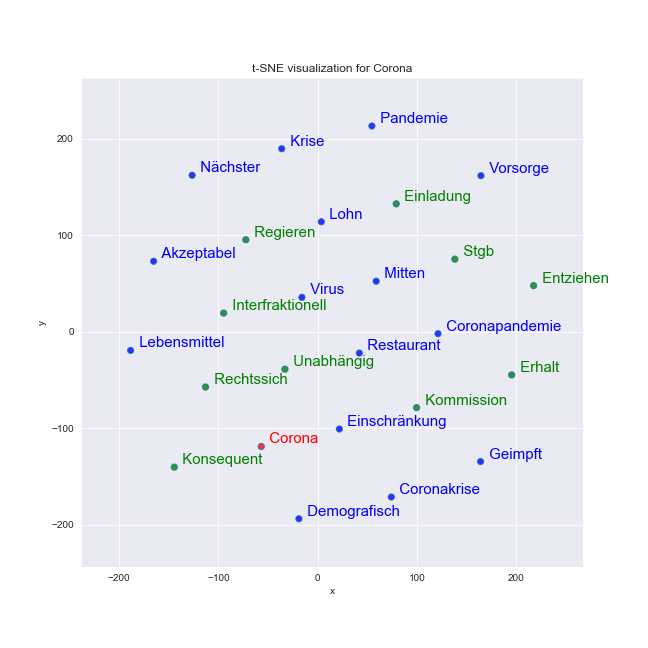

In [359]:
tsnescatterplot(model, 'corona', [i[0] for i in model.wv.most_similar(negative=["corona"])], vec_dim=DIMENSION, n_comp=PCA_COMPONENTS)

In [366]:
k = 0
tmp = []
for word in model.wv.index_to_key: 
    tmp.append(model.wv[word])
    k +=1
wordslol = ["deutschland", "freiheit", "syrien", "muslim"]
tmp = [model.wv[word] for word in wordslol]
sample_vectors = np.array(tmp)

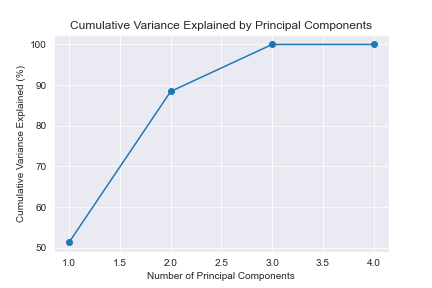

In [367]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA() # init PCA object
pca.fit(sample_vectors) # the fit function determines the new dimensions or axes to represent the data -- the result is sent back to the pca object

# Calculate cumulative variance explained
cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)*100

# Plot cumulative variance explained
plt.figure()
plt.plot(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained, '-o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained (%)")
plt.title("Cumulative Variance Explained by Principal Components")
plt.show()



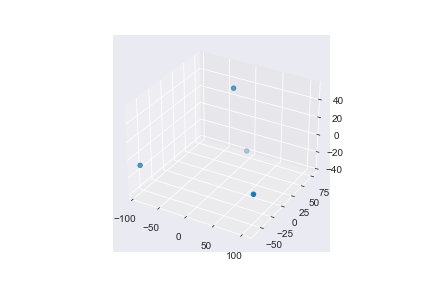

In [368]:
%matplotlib widget
result = pca.transform(sample_vectors)
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(result[:,0], result[:,1], result[:,2])